<a href="https://colab.research.google.com/github/allicodi/bsta001_final/blob/main/BSTA_001_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
caseData = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')

In [ ]:
policyData_raw = pd.read_csv('/content/drive/My Drive/COVID-19_policy.csv')
policyData_unsorted = policyData_raw[4:55] #the postcodes (state Abbrev) are not alphabetical


In [ ]:
policyData_unsorted.head()

,STATE,POSTCODE,FIPS,STEMERG,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,STAYHOME,STAYHOMENOGP,END_STHM,CLBSNS,END_BSNS,RELIGEX,FM_ALL,FMFINE,FMCITE,FMNOENF,FM_EMP,FM_END,FM_STP,ALCOPEN,ALCREST,ALCDELIV,GUNOPEN,CLREST,ENDREST,RSTOUTDR,CLGYM,ENDGYM,CLMOVIE,END_MOV,CLOSEBAR,END_BRS,END_HAIR,END_RELG,ENDRETL,BCLBAR2,CLBAR2,CLMV2,...,UICLDCR,UIEXTND,UIMAXAMT,UIMAXEXT,UIMAXDUR,UIMAXCAR,UIMINBP,UIQTRNEED,UIOUTHQBP,UIREQBPL2Q,UIBPEARN300,UITAXWA,UIMINTAXR,UIMAXTAXR,UIAVGBFTAUG,LMABRN,TLHlBUPR,EXTOPFL,HMDLVOP,TLHLCL24,EXCEMORP,WVDEAREQ,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18,MH19,VBMEXC,VBMSIG,VBMPERM,VBMAUTOBAL,VBMAUTOAP,VBMGENELEC,Unnamed: 162
4,Alabama,AL,1,3/13/20,3/20/20,3/20/20,5/23/20,3/19/20,4/4/20,0,4/30/20,3/28/20,4/30/20,0,7/16/20,0,0,1,5/11/20,0,0,1,3/24/20,3/24/20,1,3/19/20,5/11/20,0,3/28/20,5/11/20,3/28/20,5/22/20,3/19/20,5/11/20,5/11/20,5/11/20,4/30/20,0,0,0,...,0,0,275,875,20,39,2340,2,780,0,Max Benefit < $300,8000,0.65,6.8,$250.77,1,0,0,0,3/20/20,0,0,0,0,93.24,4887871,52420,"3,261",5.6,16.8,43.1,"54,352",100.7,0,1,0,0,0,10/29/20,NaN
5,Alaska,AK,2,3/11/20,3/16/20,0,0,0,3/28/20,0,4/24/20,3/24/20,4/24/20,0,4/24/20,1,1,0,4/24/20,5/22/20,0,1,3/17/20,3/17/20,1,3/18/20,4/24/20,0,3/18/20,5/8/20,3/18/20,5/8/20,3/18/20,5/8/20,4/24/20,5/8/20,4/24/20,0,0,0,...,1,0,370,970,26,39,2500,2,250,0,13636.36,41500,1,5.4,$443.23,1,0,0,0,0,0,0,0,1,1.11,737438,665384,"1,907",6.8,10.9,32.8,"4,453",429.9,0,1,0,0,2,10/24/20,NaN
6,Arizona,AZ,4,3/11/20,3/16/20,0,0,0,3/31/20,0,5/16/20,3/31/20,5/8/20,1,0,0,0,0,5/8/20,0,3/30/20,1,3/19/20,3/19/20,1,3/21/20,5/11/20,0,3/21/20,5/13/20,3/21/20,5/16/20,3/21/20,5/16/20,5/8/20,0,5/8/20,6/29/20,6/29/20,6/29/20,...,1,0,240,840,26,39,7020,2,2340,0,Max Benefit < $300,7000,0.05,12.85,$237.99,0,0,0,0,0,3/11/20,0,1,1,62.91,7171646,113990,"10,007",5.4,14,39.1,"59,282",132.9,0,0,0,0,0,10/23/20,NaN
7,Arkansas,AR,5,3/11/20,3/17/20,0,0,3/13/20,0,0,0,4/6/20,5/4/20,0,7/20/20,1,1,0,5/11/20,0,0,1,3/19/20,3/19/20,1,3/20/20,5/11/20,0,3/20/20,5/4/20,3/20/20,5/18/20,3/20/20,5/19/20,5/6/20,0,5/18/20,0,0,0,...,0,0,451,1051,16,33,2835,2,1,0,31200,7000,0.1,6,$223.84,1,0,0,0,0,0,0,0,1,56.67,3013825,53179,"2,717",4.5,17.2,43.5,"32,336",231.6,0,0,0,0,0,10/27/20,NaN
8,California,CA,6,3/4/20,3/23/20,0,0,0,3/19/20,0,0,3/19/20,5/8/20,0,6/18/20,0,0,1,5/5/20,0,0,1,3/19/20,3/19/20,0,3/16/20,5/18/20,0,3/19/20,0,3/19/20,0,3/16/20,0,8/28/20,5/25/20,5/8/20,0,0,7/13/20,...,0,0,450,1050,26,39,1125,2,225,0,6900,7000,1.5,6.2,$282.35,0,0,0,0,0,0,0,1,1,241.65,39557045,163695,"151,278",5.5,12.8,33.3,"268,818",356.2,0,0,0,1,0,0,NaN


In [ ]:
caseData.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2020-11-24,AK,A,116.0,116.0,13,NaN,631.0,631.0,144.0,14,NaN,NaN,915732.0,9801,NaN,NaN,909608.0,NaN,21.0,27669.0,NaN,584,0,NaN,NaN,NaN,NaN,33242.0,7165.0,NaN,0,943401.0,10385,NaN,NaN,NaN,NaN,NaN,0,943401.0,10385
1,2020-11-24,AL,A,3472.0,3165.0,13,307.0,24160.0,24160.0,1428.0,218,2211.0,NaN,1347017.0,9276,NaN,NaN,NaN,1276.0,NaN,236865.0,197848.0,2785,0,NaN,NaN,NaN,NaN,NaN,90702.0,NaN,0,1544865.0,11237,NaN,NaN,70247.0,NaN,NaN,0,1544865.0,11237
2,2020-11-24,AR,A+,2405.0,2208.0,18,197.0,8620.0,8620.0,988.0,97,NaN,387.0,1487077.0,11309,NaN,NaN,1487077.0,951.0,160.0,148312.0,130826.0,2122,0,NaN,3300.0,NaN,20993.0,NaN,128831.0,NaN,0,1617903.0,12730,NaN,21856.0,NaN,122446.0,NaN,0,1617903.0,12730
3,2020-11-24,AS,D,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,1988.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1988.0,0,NaN,NaN,NaN,NaN,NaN,0,1988.0,0
4,2020-11-24,AZ,A+,6515.0,6036.0,51,479.0,24666.0,24666.0,2084.0,205,NaN,474.0,1842033.0,10734,NaN,NaN,NaN,NaN,310.0,306868.0,298008.0,4544,0,NaN,NaN,NaN,NaN,NaN,49234.0,NaN,0,2140041.0,15168,357863.0,NaN,NaN,NaN,2140041.0,15168,NaN,0


In [ ]:
#gather dates of face mask mandates and their respective states
dateOfFM = policyData_unsorted.FM_ALL
state = policyData_unsorted.POSTCODE

caseData['date'] = caseData['date'].astype('datetime64[ns]')

pd.to_datetime(dateOfFM, errors = 'coerce')

4    2020-07-16
5    2020-04-24
6           NaT
7    2020-07-20
8    2020-06-18
9    2020-07-16
10   2020-04-20
11   2020-04-28
12   2020-04-17
13          NaT
14          NaT
15   2020-04-16
16          NaT
17   2020-05-01
18   2020-07-27
19          NaT
20   2020-07-03
21   2020-05-11
22          NaT
23   2020-05-01
24   2020-04-18
25   2020-05-06
26   2020-04-27
27   2020-07-24
28   2020-08-05
29          NaT
30          NaT
31          NaT
32   2020-06-26
33          NaT
34   2020-04-08
35   2020-05-15
36   2020-04-17
37   2020-06-26
38          NaT
39   2020-07-23
40          NaT
41   2020-07-01
42   2020-07-01
43   2020-04-18
44          NaT
45          NaT
46          NaT
47   2020-07-03
48   2020-04-10
49   2020-08-01
50   2020-05-29
51   2020-06-26
52   2020-07-07
53   2020-08-01
54          NaT
Name: FM_ALL, dtype: datetime64[ns]

In [ ]:
caseData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14955 entries, 0 to 14954
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              14955 non-null  datetime64[ns]
 1   state                             14955 non-null  object        
 2   dataQualityGrade                  13700 non-null  object        
 3   death                             14135 non-null  float64       
 4   deathConfirmed                    6454 non-null   float64       
 5   deathIncrease                     14955 non-null  int64         
 6   deathProbable                     4780 non-null   float64       
 7   hospitalized                      8977 non-null   float64       
 8   hospitalizedCumulative            8977 non-null   float64       
 9   hospitalizedCurrently             11880 non-null  float64       
 10  hospitalizedIncrease              14955 non-nu

In [ ]:
#keeping only necessary columns
dataFinal = caseData.drop(['dataQualityGrade' , 'death' ,	'deathConfirmed', 	'deathIncrease' ,	'deathProbable' ,	'hospitalized'	,'hospitalizedCumulative'	,'hospitalizedCurrently'	,'hospitalizedIncrease'	,'inIcuCumulative'	,'inIcuCurrently'	,'negative'	,'negativeIncrease'	,'negativeTestsAntibody'	,'negativeTestsPeopleAntibody',	'negativeTestsViral',	'onVentilatorCumulative'	,'onVentilatorCurrently'	,'positive'	,'positiveCasesViral', 'positiveScore'	,'positiveTestsAntibody'	,'positiveTestsAntigen'	,'positiveTestsPeopleAntibody'	,'positiveTestsPeopleAntigen'	,'positiveTestsViral'	,'recovered'	,'totalTestEncountersViral'	,'totalTestEncountersViralIncrease'	,'totalTestResults'	,'totalTestResultsIncrease'	,'totalTestsAntibody'	,'totalTestsAntigen'	,'totalTestsPeopleAntibody',	'totalTestsPeopleAntigen'	,'totalTestsPeopleViral'	,'totalTestsPeopleViralIncrease'	,'totalTestsViral'	,'totalTestsViralIncrease'], axis = 1)
print(dataFinal)

            date state  positiveIncrease
0     2020-11-24    AK               584
1     2020-11-24    AL              2785
2     2020-11-24    AR              2122
3     2020-11-24    AS                 0
4     2020-11-24    AZ              4544
...          ...   ...               ...
14950 2020-01-24    WA                 0
14951 2020-01-23    MA                 0
14952 2020-01-23    WA                 0
14953 2020-01-22    MA                 0
14954 2020-01-22    WA                 0

[14955 rows x 3 columns]


In [ ]:
# creating list of all states/territories with case data
stateAbbrev = []

stateName = caseData.state
for i in stateName: 
    if i not in stateAbbrev: 
        stateAbbrev.append(i) 

print(stateAbbrev)
print(len(stateAbbrev))

['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']
56


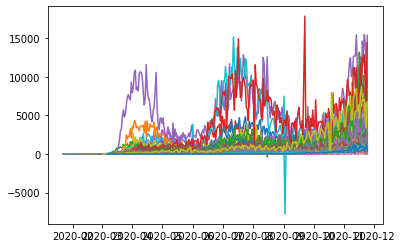

<Figure size 1440x216 with 0 Axes>

In [ ]:
from matplotlib.pyplot import figure
casesByState = [] #empty list to hold state cases
removeStates = ['AS','GU','MP','PR','VI'] #territories not included in analysis

for j in stateAbbrev: #remove unanalyzed territories
  if j == 'AS':
    stateAbbrev.remove(j)
  if j == 'GU':
    stateAbbrev.remove(j)
  if j == 'MP':
    stateAbbrev.remove(j)
  if j == 'PR':
    stateAbbrev.remove(j)
  if j == 'VI':
    stateAbbrev.remove(j)
  else:
    pass
#print(stateAbbrev)

for j in stateAbbrev: # for loop for separating case data by state
  stateCases = dataFinal.loc[dataFinal['state'] == j] 
  casesByState.append(stateCases)
  #graph of state case increases over time
  x = stateCases.date
  y = stateCases.positiveIncrease
  plt.plot(x, y)
  #fig.set_size_inches(17, 8.5, forward=True)
fig= plt.figure(figsize=(20,3)) #won't size up, if put it in for loop you get individual graphs
plt.show()

#print(casesByState)

In [ ]:
#data needs cleaning, one state has greater than -5000 pos. inc

In [ ]:
FMdf = pd.DataFrame(dateOfFM) #making data frame of face mask mandates
FMdf['State'] = (state) #adding corresponding states to FM mandates

for col in FMdf.columns: #checking column titles
  print(col)

print(FMdf)
#len(FMdf)

FM_ALL
State
     FM_ALL State
4   7/16/20    AL
5   4/24/20    AK
6         0    AZ
7   7/20/20    AR
8   6/18/20    CA
9   7/16/20    CO
10  4/20/20    CT
11  4/28/20    DE
12  4/17/20    DC
13        0    FL
14        0    GA
15  4/16/20    HI
16        0    ID
17   5/1/20    IL
18  7/27/20    IN
19        0    IA
20   7/3/20    KS
21  5/11/20    KY
22        0    LA
23   5/1/20    ME
24  4/18/20    MD
25   5/6/20    MA
26  4/27/20    MI
27  7/24/20    MN
28   8/5/20    MS
29        0    MO
30        0    MT
31        0    NE
32  6/26/20    NV
33        0    NH
34   4/8/20    NJ
35  5/15/20    NM
36  4/17/20    NY
37  6/26/20    NC
38        0    ND
39  7/23/20    OH
40        0    OK
41   7/1/20    OR
42   7/1/20    PA
43  4/18/20    RI
44        0    SC
45        0    SD
46        0    TN
47   7/3/20    TX
48  4/10/20    UT
49   8/1/20    VT
50  5/29/20    VA
51  6/26/20    WA
52   7/7/20    WV
53   8/1/20    WI
54        0    WY


In [ ]:
#HI PEGGY: im stuck here, goal: write a for loop for easy selection of dates, include FM mandate dates from above 
for s in FMdf.State:  
  print(FMdf[s])

KeyError: ignored

In [ ]:
# everything from here down was manual, should be correct FM dates w/ state though! We can delete this later?

#AK = dataFinal.loc[dataFinal['state'] == 'AK'] #1
#AL = dataFinal.loc[dataFinal['state'] == 'AL'] #2
#AR = dataFinal.loc[dataFinal['state'] == 'AR'] #3
#AS = dataFinal.loc[dataFinal['state'] == 'AS'] #4 not mainland
#AZ = dataFinal.loc[dataFinal['state'] == 'AZ'] #5
#CA = dataFinal.loc[dataFinal['state'] == 'CA'] #6
#CO = dataFinal.loc[dataFinal['state'] == 'CO'] #7
#CT = dataFinal.loc[dataFinal['state'] == 'CT'] #8
#DC = dataFinal.loc[dataFinal['state'] == 'DC'] #9
#FL = dataFinal.loc[dataFinal['state'] == 'FL'] #10
#GA = dataFinal.loc[dataFinal['state'] == 'GA'] #11
#GU = dataFinal.loc[dataFinal['state'] == 'GU'] #12
#HI = dataFinal.loc[dataFinal['state'] == 'HI'] #13
#IA = dataFinal.loc[dataFinal['state'] == 'IA'] #14
#ID = dataFinal.loc[dataFinal['state'] == 'ID'] #15
#IL = dataFinal.loc[dataFinal['state'] == 'IL'] #16
#IN = dataFinal.loc[dataFinal['state'] == 'IN'] #17
#KS = dataFinal.loc[dataFinal['state'] == 'KS'] #18
#KY = dataFinal.loc[dataFinal['state'] == 'KY'] #19
#LA = dataFinal.loc[dataFinal['state'] == 'LA'] #20
#MA = dataFinal.loc[dataFinal['state'] == 'MA'] #56
#MD = dataFinal.loc[dataFinal['state'] == 'MD'] #21
#ME = dataFinal.loc[dataFinal['state'] == 'ME'] #22
#MI = dataFinal.loc[dataFinal['state'] == 'MI'] #23
#MN = dataFinal.loc[dataFinal['state'] == 'MN'] #24
#MO = dataFinal.loc[dataFinal['state'] == 'MO'] #25
#MP = dataFinal.loc[dataFinal['state'] == 'MP'] #26
#MS = dataFinal.loc[dataFinal['state'] == 'MS'] #27
#MT = dataFinal.loc[dataFinal['state'] == 'MT'] #28
#NC = dataFinal.loc[dataFinal['state'] == 'NC'] #29
#ND = dataFinal.loc[dataFinal['state'] == 'ND'] #30
#NE = dataFinal.loc[dataFinal['state'] == 'NE'] #31
#NH = dataFinal.loc[dataFinal['state'] == 'NJ'] #32
#NM = dataFinal.loc[dataFinal['state'] == 'NM'] #33
#NV = dataFinal.loc[dataFinal['state'] == 'NV'] #34
#NY = dataFinal.loc[dataFinal['state'] == 'NY'] #35
#OH = dataFinal.loc[dataFinal['state'] == 'OH'] #36
#OK = dataFinal.loc[dataFinal['state'] == 'OK'] #37
#OR = dataFinal.loc[dataFinal['state'] == 'OR'] #38
#PA = dataFinal.loc[dataFinal['state'] == 'PA'] #39
#PR = dataFinal.loc[dataFinal['state'] == 'PR'] #40
#RI = dataFinal.loc[dataFinal['state'] == 'RI'] #41
#SC = dataFinal.loc[dataFinal['state'] == 'SC'] #42
#SD = dataFinal.loc[dataFinal['state'] == 'SD'] #43
#TN = dataFinal.loc[dataFinal['state'] == 'TN'] #44
#TX = dataFinal.loc[dataFinal['state'] == 'TX'] #45
#UT = dataFinal.loc[dataFinal['state'] == 'UT'] #46
#VA = dataFinal.loc[dataFinal['state'] == 'VA'] #47
#VI = dataFinal.loc[dataFinal['state'] == 'VI'] #48
#VT = dataFinal.loc[dataFinal['state'] == 'VT'] #49
#WA = dataFinal.loc[dataFinal['state'] == 'WA'] #50
#WI = dataFinal.loc[dataFinal['state'] == 'WI'] #51
#WV = dataFinal.loc[dataFinal['state'] == 'WV'] #52
#WY = dataFinal.loc[dataFinal['state'] == 'WY'] #53
#NJ = dataFinal.loc[dataFinal['state'] == 'NJ'] #54
#DE = dataFinal.loc[dataFinal['state'] == 'DE'] #55

In [ ]:
AKBefore = AK.loc[(AK.date>='2020-4-10') & ((AK.date<='2020-4-24')),:] #4/24/20
AKAfter = AK.loc[(AK.date>='2020-5-8') & ((AK.date<='2020-5-22')),:]

ALBefore = AL.loc[(AL.date>='2020-7-2') & ((AL.date<='2020-7-16')),:] #7/16/20
ALAfter = AL.loc[(AL.date>='2020-7-30') & ((AL.date<='2020-8-13')),:]

ARBefore = AR.loc[(AR.date>='2020-7-6') & ((AR.date<='2020-7-20')),:] #7/20/20
ARAfter = AR.loc[(AR.date>='2020-8-3') & ((AR.date<='2020-8-17')),:]

#AZ=0

CABefore = CA.loc[(CA.date>='2020-6-4') & ((CA.date<='2020-6-18')),:] #6/18/20
CAAfter = CA.loc[(CA.date>='2020-7-2') & ((CA.date<='2020-7-16')),:]

COBefore = CO.loc[(CO.date>='2020-7-2') & ((CO.date<='2020-7-16')),:] #7/16/20
COAfter = CO.loc[(CO.date>='2020-7-30') & ((CO.date<='2020-8-13')),:]

CTBefore = CT.loc[(CT.date>='2020-4-6') & ((CT.date<='2020-4-20')),:] #4/20/20
CTAfter = CT.loc[(CT.date>='2020-5-4') & ((CT.date<='2020-5-18')),:]

DEBefore = DE.loc[(DE.date>='2020-4-14') & ((DE.date<='2020-4-28')),:] #4/28/20
DEAfter = DE.loc[(DE.date>='2020-5-12') & ((DE.date<='2020-8-26')),:]

DCBefore = CA.loc[(CA.date>='2020-4-3') & ((CA.date<='2020-4-17')),:] #4/17/20
DCAfter = CA.loc[(CA.date>='2020-5-1') & ((CA.date<='2020-5-15')),:]

#FL = 0 
#GA = 0

HIBefore = HI.loc[(HI.date>='2020-7-2') & ((HI.date<='2020-7-16')),:] #4/16/20
HIAfter = HI.loc[(HI.date>='2020-7-30') & ((HI.date<='2020-8-13')),:]

#ID=0

ILBefore = IL.loc[(IL.date>='2020-4-17') & ((IL.date<='2020-5-1')),:] #5/1/20
ILAfter = IL.loc[(IL.date>='2020-5-15') & ((IL.date<='2020-5-29')),:]

INBefore = IN.loc[(IN.date>='2020-7-13') & ((IN.date<='2020-7-27')),:] #7/27/20
INAfter = IN.loc[(IN.date>='2020-8-10') & ((IN.date<='2020-8-24')),:]

#IA = 0

KSBefore = KS.loc[(KS.date>='2020-6-19') & ((KS.date<='2020-7-3')),:] #7/3/20
KSAfter = KS.loc[(KS.date>='2020-7-17') & ((KS.date<='2020-7-31')),:]

KYBefore = KY.loc[(KY.date>='2020-4-27') & ((KY.date<='2020-5-11')),:] #5/11/20
KYAfter = KY.loc[(KY.date>='2020-5-25') & ((KY.date<='2020-6-8')),:]

# LA = 0

MEBefore = ME.loc[(ME.date>='2020-4-17') & ((ME.date<='2020-5-1')),:] #5/1/20
MEAfter = ME.loc[(ME.date>='2020-5-15') & ((ME.date<='2020-5-29')),:]

MDBefore = MD.loc[(MD.date>='2020-4-4') & ((MD.date<='2020-4-18')),:] #4/18/20
MDAfter = MD.loc[(MD.date>='2020-5-2') & ((MD.date<='2020-5-16')),:]

MABefore = MA.loc[(MA.date>='2020-4-22') & ((MA.date<='2020-5-6')),:] #5/6/20
MAAfter = MA.loc[(MA.date>='2020-5-20') & ((MA.date<='2020-6-3')),:]

MIBefore = MI.loc[(MI.date>='2020-4-13') & ((MI.date<='2020-4-27')),:] #4/27/20
MIAfter = MI.loc[(MI.date>='2020-5-11') & ((MI.date<='2020-5-25')),:]

MNBefore = MN.loc[(MN.date>='2020-7-10') & ((MN.date<='2020-7-24')),:] #7/24/20
MNAfter = MN.loc[(MN.date>='2020-7-30') & ((MN.date<='2020-8-7')),:]

MSBefore = MS.loc[(MS.date>='2020-7-22') & ((MS.date<='2020-8-5')),:] #8/5/20
MSAfter = MS.loc[(MS.date>='2020-8-19') & ((MS.date<='2020-9-2')),:]

#MO = 0
#MT = 0
#NE = 0

NVBefore = NV.loc[(NV.date>='2020-6-12') & ((NV.date<='2020-6-26')),:] #6/26/20
NVAfter = NV.loc[(NV.date>='2020-7-10') & ((NV.date<='2020-7-24')),:]

#NH = 0

NJBefore = NJ.loc[(NJ.date>='2020-3-25') & ((NJ.date<='2020-4-8')),:] #4/8/20
NJAfter = NJ.loc[(NJ.date>='2020-4-22') & ((NJ.date<='2020-5-6')),:]

NMBefore = NM.loc[(NM.date>='2020-5-1') & ((NM.date<='2020-5-15')),:] #5/15/20
NMAfter = NM.loc[(NM.date>='2020-5-29') & ((NM.date<='2020-6-12')),:]

NYBefore = NY.loc[(NY.date>='2020-4-3') & ((NY.date<='2020-4-17')),:] #4/17/20
NYAfter = NY.loc[(NY.date>='2020-5-1') & ((NY.date<='2020-5-15')),:]

NCBefore = NC.loc[(NC.date>='2020-6-12') & ((NC.date<='2020-6-26')),:] #6/26/20
NCAfter = NC.loc[(NC.date>='2020-7-10') & ((NC.date<='2020-7-24')),:]

#ND = 0

OHBefore = OH.loc[(OH.date>='2020-7-9') & ((OH.date<='2020-7-23')),:] #7/23/20
OHAfter = OH.loc[(OH.date>='2020-8-6') & ((OH.date<='2020-8-20')),:]

#OK = 0

ORBefore = OR.loc[(OR.date>='2020-6-16') & ((OR.date<='2020-7-1')),:] #7/1/20
ORAfter = OR.loc[(OR.date>='2020-7-15') & ((OR.date<='2020-7-29')),:]

PABefore = PA.loc[(PA.date>='2020-6-16') & ((PA.date<='2020-7-1')),:] #7/1/20
PAAfter = PA.loc[(PA.date>='2020-7-15') & ((PA.date<='2020-7-29')),:]

RIBefore = RI.loc[(RI.date>='2020-4-4') & ((RI.date<='2020-4-18')),:] #4/18/20
RIAfter = RI.loc[(RI.date>='2020-5-2') & ((RI.date<='2020-5-16')),:]

#SC = 0
#SD = 0
#TN = 0

TXBefore = TX.loc[(TX.date>='2020-6-19') & ((TX.date<='2020-7-3')),:] #7/3/20
TXAfter = TX.loc[(TX.date>='2020-7-17') & ((TX.date<='2020-7-31')),:]

UTBefore = UT.loc[(UT.date>='2020-3-27') & ((UT.date<='2020-4-10')),:] #4/10/20
UTAfter = UT.loc[(UT.date>='2020-4-24') & ((UT.date<='2020-5-8')),:]

VTBefore = VT.loc[(VT.date>='2020-7-18') & ((VT.date<='2020-8-1')),:] #8/1/20
VTAfter = VT.loc[(VT.date>='2020-8-15') & ((VT.date<='2020-8-29')),:]

VABefore = VA.loc[(VA.date>='2020-5-15') & ((VA.date<='2020-5-29')),:] #5/29/20
VAAfter = VA.loc[(VA.date>='2020-6-12') & ((VA.date<='2020-6-16')),:]

WABefore = WA.loc[(WA.date>='2020-6-12') & ((WA.date<='2020-6-26')),:] #6/26/20
WAAfter = WA.loc[(WA.date>='2020-7-10') & ((WA.date<='2020-7-24')),:]

WVBefore = WV.loc[(WV.date>='2020-6-23') & ((WV.date<='2020-7-7')),:] #7/7/20
WVAfter = WV.loc[(WV.date>='2020-7-21') & ((WV.date<='2020-8-4')),:]

WIBefore = WI.loc[(WI.date>='2020-7-18') & ((WI.date<='2020-8-1')),:] #8/1/20
WIAfter = WI.loc[(WI.date>='2020-8-15') & ((WI.date<='2020-8-29')),:]

#WY = 0

In [ ]:
print(AKBefore)
print(AKAfter)

            date state  positiveIncrease
11984 2020-04-24    AK                 2
12040 2020-04-23    AK                 2
12096 2020-04-22    AK                 6
12152 2020-04-21    AK                 8
12208 2020-04-20    AK                 2
12264 2020-04-19    AK                 5
12320 2020-04-18    AK                 5
12376 2020-04-17    AK                 9
12432 2020-04-16    AK                 7
12488 2020-04-15    AK                 8
12544 2020-04-14    AK                 8
12600 2020-04-13    AK                 5
12656 2020-04-12    AK                15
12712 2020-04-11    AK                11
12768 2020-04-10    AK                11
            date state  positiveIncrease
10416 2020-05-22    AK                 2
10472 2020-05-21    AK                 0
10528 2020-05-20    AK                 3
10584 2020-05-19    AK                 0
10640 2020-05-18    AK                 3
10696 2020-05-17    AK                 4
10752 2020-05-16    AK                 4
10808 2020-05-15

<BarContainer object of 15 artists>

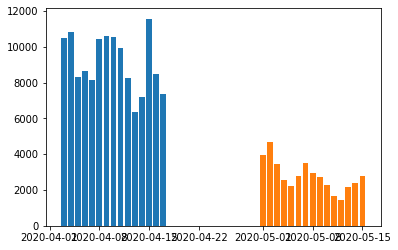

In [ ]:
plt.bar(NYBefore.date, NYBefore.positiveIncrease)
plt.bar(NYAfter.date, NYAfter.positiveIncrease)

In [ ]:
#avg pos increases
avgCasesBefore = []
avgCasesBefore.append(np.mean(AKBefore.positiveIncrease))
avgCasesBefore.append(np.mean(ALBefore.positiveIncrease))
avgCasesBefore.append(np.mean(ARBefore.positiveIncrease))
avgCasesBefore.append(np.mean(CABefore.positiveIncrease))
avgCasesBefore.append(np.mean(COBefore.positiveIncrease))
avgCasesBefore.append(np.mean(CTBefore.positiveIncrease))
avgCasesBefore.append(np.mean(DEBefore.positiveIncrease))
avgCasesBefore.append(np.mean(DCBefore.positiveIncrease))
avgCasesBefore.append(np.mean(HIBefore.positiveIncrease))
avgCasesBefore.append(np.mean(ILBefore.positiveIncrease))
avgCasesBefore.append(np.mean(INBefore.positiveIncrease))
avgCasesBefore.append(np.mean(KSBefore.positiveIncrease))
avgCasesBefore.append(np.mean(KYBefore.positiveIncrease))
avgCasesBefore.append(np.mean(MEBefore.positiveIncrease))
avgCasesBefore.append(np.mean(MDBefore.positiveIncrease))
avgCasesBefore.append(np.mean(MABefore.positiveIncrease))
avgCasesBefore.append(np.mean(MIBefore.positiveIncrease))
avgCasesBefore.append(np.mean(MNBefore.positiveIncrease))
avgCasesBefore.append(np.mean(MSBefore.positiveIncrease))
avgCasesBefore.append(np.mean(NVBefore.positiveIncrease))
avgCasesBefore.append(np.mean(NJBefore.positiveIncrease))
avgCasesBefore.append(np.mean(NMBefore.positiveIncrease))
avgCasesBefore.append(np.mean(NYBefore.positiveIncrease))
avgCasesBefore.append(np.mean(NCBefore.positiveIncrease))
avgCasesBefore.append(np.mean(OHBefore.positiveIncrease))
avgCasesBefore.append(np.mean(ORBefore.positiveIncrease))
avgCasesBefore.append(np.mean(PABefore.positiveIncrease))
avgCasesBefore.append(np.mean(RIBefore.positiveIncrease))
avgCasesBefore.append(np.mean(TXBefore.positiveIncrease))
avgCasesBefore.append(np.mean(UTBefore.positiveIncrease))
avgCasesBefore.append(np.mean(VABefore.positiveIncrease))
avgCasesBefore.append(np.mean(VTBefore.positiveIncrease))
avgCasesBefore.append(np.mean(WABefore.positiveIncrease))
avgCasesBefore.append(np.mean(WVBefore.positiveIncrease))
avgCasesBefore.append(np.mean(WIBefore.positiveIncrease))
print(avgCasesBefore)

[6.933333333333334, 1475.0666666666666, 714.5333333333333, 2894.133333333333, 379.8, 942.6666666666666, 196.66666666666666, 1222.4666666666667, 25.0, 2021.4666666666667, 753.0, 282.53333333333336, 169.0, 21.8, 636.6666666666666, 1923.8, 869.5333333333333, 621.6666666666666, 1194.6666666666667, 364.06666666666666, 2917.4666666666667, 150.06666666666666, 9150.733333333334, 1289.1333333333334, 1333.6666666666667, 194.4375, 507.5625, 269.1333333333333, 5578.733333333334, 113.33333333333333, 981.3333333333334, 5.8, 469.06666666666666, 60.6, 932.6666666666666]


In [ ]:
#avg pos increases
avgCasesAfter = []
avgCasesAfter.append(np.mean(AKAfter.positiveIncrease))
avgCasesAfter.append(np.mean(ALAfter.positiveIncrease))
avgCasesAfter.append(np.mean(ARAfter.positiveIncrease))
avgCasesAfter.append(np.mean(CAAfter.positiveIncrease))
avgCasesAfter.append(np.mean(COAfter.positiveIncrease))
avgCasesAfter.append(np.mean(CTAfter.positiveIncrease))
avgCasesAfter.append(np.mean(DEAfter.positiveIncrease))
avgCasesAfter.append(np.mean(DCAfter.positiveIncrease))
avgCasesAfter.append(np.mean(HIAfter.positiveIncrease))
avgCasesAfter.append(np.mean(ILAfter.positiveIncrease))
avgCasesAfter.append(np.mean(INAfter.positiveIncrease))
avgCasesAfter.append(np.mean(KSAfter.positiveIncrease))
avgCasesAfter.append(np.mean(KYAfter.positiveIncrease))
avgCasesAfter.append(np.mean(MEAfter.positiveIncrease))
avgCasesAfter.append(np.mean(MDAfter.positiveIncrease))
avgCasesAfter.append(np.mean(MAAfter.positiveIncrease))
avgCasesAfter.append(np.mean(MIAfter.positiveIncrease))
avgCasesAfter.append(np.mean(MNAfter.positiveIncrease))
avgCasesAfter.append(np.mean(MSAfter.positiveIncrease))
avgCasesAfter.append(np.mean(NVAfter.positiveIncrease))
avgCasesAfter.append(np.mean(NJAfter.positiveIncrease))
avgCasesAfter.append(np.mean(NMAfter.positiveIncrease))
avgCasesAfter.append(np.mean(NYAfter.positiveIncrease))
avgCasesAfter.append(np.mean(NCAfter.positiveIncrease))
avgCasesAfter.append(np.mean(OHAfter.positiveIncrease))
avgCasesAfter.append(np.mean(ORAfter.positiveIncrease))
avgCasesAfter.append(np.mean(PAAfter.positiveIncrease))
avgCasesAfter.append(np.mean(RIAfter.positiveIncrease))
avgCasesAfter.append(np.mean(TXAfter.positiveIncrease))
avgCasesAfter.append(np.mean(UTAfter.positiveIncrease))
avgCasesAfter.append(np.mean(VAAfter.positiveIncrease))
avgCasesAfter.append(np.mean(VTAfter.positiveIncrease))
avgCasesAfter.append(np.mean(WAAfter.positiveIncrease))
avgCasesAfter.append(np.mean(WVAfter.positiveIncrease))
avgCasesAfter.append(np.mean(WIAfter.positiveIncrease))
print(avgCasesAfter)
len(avgCasesAfter)

[2.1333333333333333, 1451.6666666666667, 660.2666666666667, 8002.6, 428.2, 588.6, 97.39252336448598, 1734.6, 170.33333333333334, 1967.8666666666666, 884.2666666666667, 458.6, 193.66666666666666, 44.06666666666667, 966.4, 911.1333333333333, 573.2666666666667, 693.1111111111111, 743.8666666666667, 1065.4, 2633.5333333333333, 144.13333333333333, 2762.733333333333, 1976.4, 1046.5333333333333, 327.73333333333335, 903.1333333333333, 238.8, 8552.666666666666, 153.8, 536.8, 6.933333333333334, 799.7333333333333, 127.26666666666667, 736.6]


35

In [ ]:
#states with FM
statesWithFM = ['AK','AL','AR', 'CA', 'CO', 'CT', 'DE','DC','HI','IL','IN','KS','KY','ME','MD','MA','MI','MN','MS','NV','NJ','NM','NY','NC','OH','OR','PA','RI','TX','UT','VA','VT','WA','WV','WI']

len(statesWithFM)

35

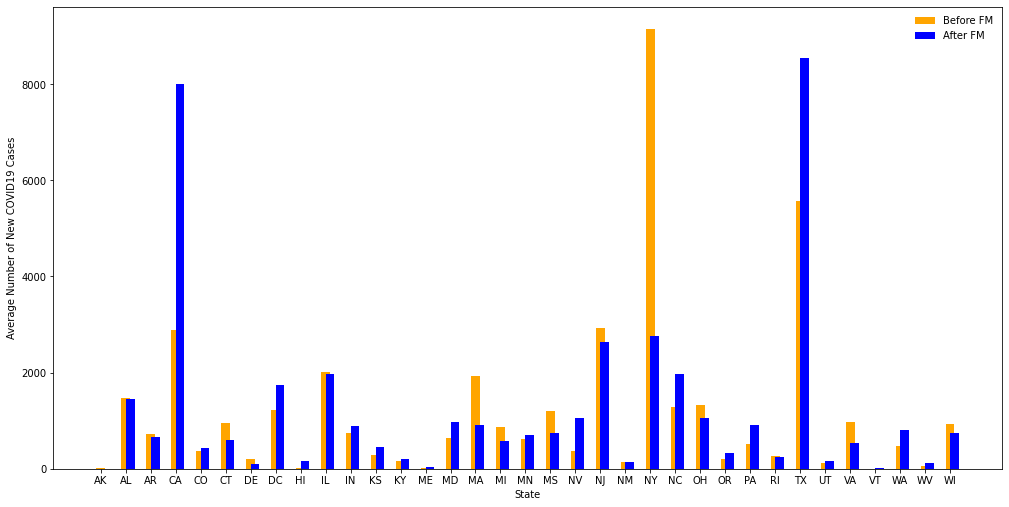

In [ ]:
#plotting
from matplotlib.pyplot import figure

#x = np.arange(len(statesWithFM))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(statesWithFM, avgCasesBefore, width, align= 'center', color='orange', label='Before FM')
rects2 = ax.bar(statesWithFM, avgCasesAfter, width, align= 'edge', color='blue', label='After FM')
ax.set_ylabel('Average Number of New COVID19 Cases')
ax.set_xlabel('State')
ax.set_xticklabels(statesWithFM)
ax.legend(frameon=False)
fig.set_size_inches(17, 8.5, forward=True)